In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Utilities import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
import matplotlib.pyplot as plt
import numpy as np
import os, yaml
#import pybinding as pb

In [3]:
dry_run = False
rsync_str = "rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} "
if dry_run: rsync_str += '--dry-run '
ssh_str = '-e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/GW_HF_analysis/ '
dest_path = 'GW_HF_analysis'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)

rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} -e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/GW_HF_analysis/ '/m100_work/IscrC_XEXIN/Germanene/GW_HF_analysis'


In [ ]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 2
ntasks_per_node = 16
cpus_per_task = 2
omp_num_threads = 2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True,reformat=False) #,clean_restart=False,skip=False,fatlog=True)
code.global_options()

In [3]:
# RunRules for m100
nodes = 8
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PhoGra',#,qos='m100_qos_bprod'
                memory='230GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr,reformat=False)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 8,
 'ntasks_per_node': 4,
 'cpus_per_task': 32,
 'omp_num_threads': 8,
 'gpus_per_node': 4,
 'memory': '230GB',
 'time': '23:59:00',
 'partition': 'm100_usr_prod',
 'account': 'IscrC_PhoGra',
 'qos': None,
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False,
 'reformat': False}

# GW convergence analysis of the Germanene

We perform a new convergence study to determine the GW corrections. We use the results
of the previous analysis and we perform only specific convergence tests.

In particular we make usage of the _slab z_ option to implement the cutoff of the Coulomb potential in the $z$ direction.

## HF Analysis for RIM and Coulomb cutoff parameters

As a first step we use this runlevel to study the convergence properties of the RIM and Coulomb cutoff procedures.

This analysis is performed with a 30x30x1 k-points sampling.

In [4]:
#source_dir = 'DFT_analysis/kpoints_30-nbnds_700.save'
#run_dir = 'GW_HF_analysis/kpoints_30-nbnds_700'

source_dir = 'DFT_analysis-vac_4/kpoints_30-nbnds_700.save'
run_dir = 'GW_HF_analysis/kpoints_30-nbnds_700-vac_4'


Tools.build_SAVE(source_dir,run_dir,command='mpirun -np 1 p2y')

Create folder GW_HF_analysis/kpoints_30-nbnds_700-vac_4
Executing command: cd DFT_analysis-vac_4/kpoints_30-nbnds_700.save; mpirun -np 1 p2y
Create a symlink of /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis-vac_4/kpoints_30-nbnds_700.save/SAVE in GW_HF_analysis/kpoints_30-nbnds_700-vac_4
Executing command: cd GW_HF_analysis/kpoints_30-nbnds_700-vac_4;OMP_NUM_THREADS=1 mpirun -np 1 yambo


We compute the HF gap at the $\Gamma$ and $K$ point and use these values to study the convergence
of the RIM and cutoff procedures.

Here we define the parameters common to all the runs.

In [5]:
start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index, K_index = 1, 91

#EXXRLvcs = 40000 # RL # cutoff used with celldm3=6, corresponds to 50 Ha
#EXXRLVcs_units = 'RL'
EXXRLvcs = 50. # Ha # cutoff used with celldm3=4
EXXRLVcs_units = 'Ha'

In [6]:
inp = I.YamboInput(args='mpirun -np 1 yambo -r -x -V all',folder=run_dir)
inp.set_extendOut()
inp['variables']['EXXRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['VXCRLvcs'] = [EXXRLvcs,EXXRLVcs_units]

inp.set_bandRange(start_band,stop_band)
inp['variables']['CUTGeo'] = 'slab z'

#inp

We perform a convergence run on the RandGvec parameter

In [14]:
study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

RandQpts = 1000000 # Number of random q-points in the BZ
RandGvec = [15,30,50,100,200,300] # use the RIM for the first RandGvec G-components of the coulomb potential 
RandGvecW = 9

inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']

# append runs for the Gamma point
for randgvec in RandGvec:
    idd = 'hf-G-randqpts_%s-randgvec_%s-randgvecw_%s'%(RandQpts,randgvec,RandGvecW)
    inp.set_kRange(Gamma_index,Gamma_index)
    inp['variables']['RandGvec'] = [randgvec,'RL']
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

# append runs for the K point
for randgvec in RandGvec:
    idd = 'hf-K-randqpts_%s-randgvec_%s-randgvecw_%s'%(RandQpts,randgvec,RandGvecW)
    inp.set_kRange(K_index,K_index)
    inp['variables']['RandGvec'] = [randgvec,'RL']
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 2 parallel tasks


In [15]:
#study.runs[0]

In [16]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]] 

Run the task [0, 1] 
Skip the run of hf-G-randqpts_1000000-randgvec_15-randgvecw_9
run command: mpirun -np 16 yambo -fatlog  -F hf-G-randqpts_1000000-randgvec_30-randgvecw_9.in -J hf-G-randqpts_1000000-randgvec_30-randgvecw_9 -C hf-G-randqpts_1000000-randgvec_30-randgvecw_9
slurm submit:  cd GW_HF_analysis/kpoints_30-nbnds_700-vac_4 ; sbatch job_hf-G-randqpts_1000000-randgvec_30-randgvecw_9.sh
computation hf-G-randqpts_1000000-randgvec_30-randgvecw_9 is running...
computation hf-G-randqpts_1000000-randgvec_30-randgvecw_9 ended
Run performed in 27s
Task [0, 1] ended 
 
Run the task [2, 3] 
run command: mpirun -np 16 yambo -fatlog  -F hf-G-randqpts_1000000-randgvec_50-randgvecw_9.in -J hf-G-randqpts_1000000-randgvec_50-randgvecw_9 -C hf-G-randqpts_1000000-randgvec_50-randgvecw_9
slurm submit:  cd GW_HF_analysis/kpoints_30-nbnds_700-vac_4 ; sbatch job

We plot the values of the gap (both at $\Gamma$ and at $K$) point

In [17]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')

In [18]:
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]

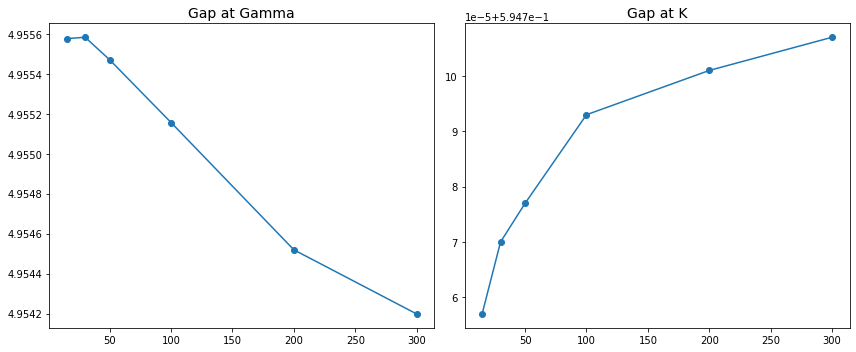

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(RandGvec,gap_G)
axes[0].scatter(RandGvec,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(RandGvec, gap_K)
axes[1].scatter(RandGvec,gap_K)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We also show the values of the valence and conduction bands

In [21]:
val_G = [r.data['hf']['Ehf'][0] for r in results_G]
cond_G = [r.data['hf']['Ehf'][1] for r in results_G]

val_K = [r.data['hf']['Ehf'][0] for r in results_K]
cond_K = [r.data['hf']['Ehf'][1] for r in results_K]

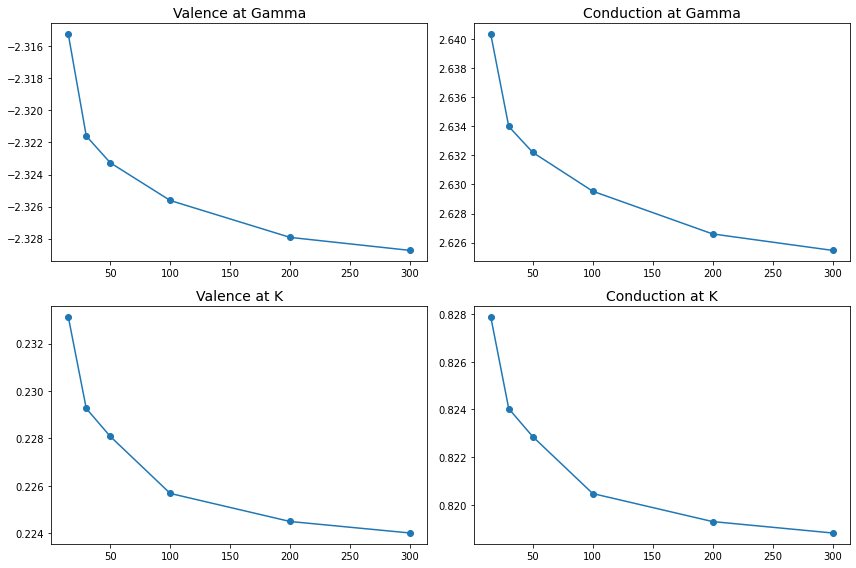

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes[0,0].plot(RandGvec,val_G)
axes[0,0].scatter(RandGvec,val_G)
axes[0,0].set_title('Valence at Gamma',size=14)
axes[0,1].plot(RandGvec, cond_G)
axes[0,1].scatter(RandGvec,cond_G)
axes[0,1].set_title('Conduction at Gamma',size=14)

axes[1,0].plot(RandGvec,val_K)
axes[1,0].scatter(RandGvec,val_K)
axes[1,0].set_title('Valence at K',size=14)
axes[1,1].plot(RandGvec, cond_K)
axes[1,1].scatter(RandGvec,cond_K)
axes[1,1].set_title('Conduction at K',size=14)

fig.tight_layout()

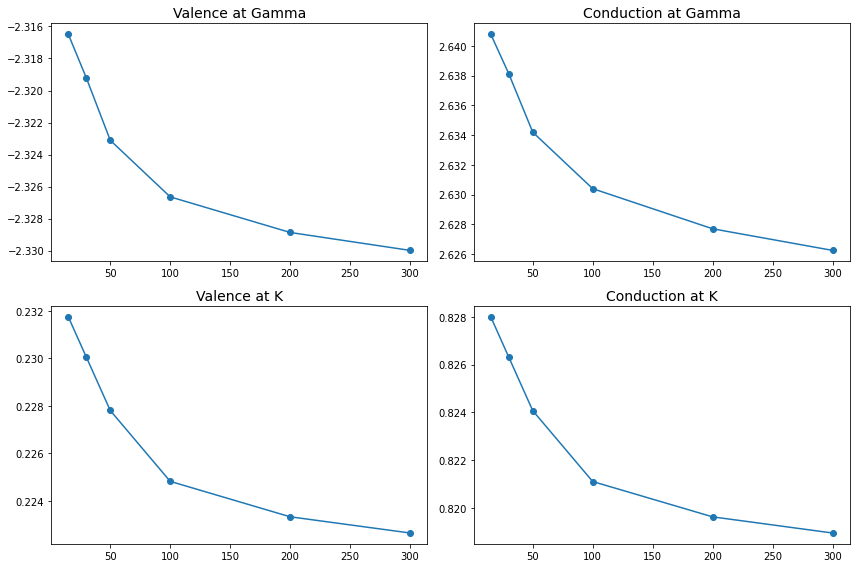

In [15]:
# results for celldm3=6

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes[0,0].plot(RandGvec,val_G)
axes[0,0].scatter(RandGvec,val_G)
axes[0,0].set_title('Valence at Gamma',size=14)
axes[0,1].plot(RandGvec, cond_G)
axes[0,1].scatter(RandGvec,cond_G)
axes[0,1].set_title('Conduction at Gamma',size=14)

axes[1,0].plot(RandGvec,val_K)
axes[1,0].scatter(RandGvec,val_K)
axes[1,0].set_title('Valence at K',size=14)
axes[1,1].plot(RandGvec, cond_K)
axes[1,1].scatter(RandGvec,cond_K)
axes[1,1].set_title('Conduction at K',size=14)

fig.tight_layout()

The states converge much slower than the associated gaps.

We perform a convergence run on the RandQpts parameter

In [24]:
study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

RandQpts = [1000000,2000000,3000000,5000000,8000000] # Number of random q-points in the BZ
RandGvec = 100 # use the RIM for the first RandGvec G-components of the coulomb potential 
RandGvecW = 9

inp['variables']['RandGvec'] = [RandGvec,'RL']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']

# append runs for the Gamma point
for randqpts in RandQpts:
    idd = 'hf-G-randqpts_%s-randgvec_%s-randgvecw_%s'%(randqpts,RandGvec,RandGvecW)
    inp.set_kRange(Gamma_index,Gamma_index)
    inp['variables']['RandQpts'] = [randqpts,'']
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

# append runs for the K point
for randqpts in RandQpts:
    idd = 'hf-K-randqpts_%s-randgvec_%s-randgvecw_%s'%(randqpts,RandGvec,RandGvecW)
    inp.set_kRange(K_index,K_index)
    inp['variables']['RandQpts'] = [randqpts,'']
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 2 parallel tasks


In [25]:
#study.runs[3]

In [26]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]] 

Run the task [0, 1] 
Skip the run of hf-G-randqpts_1000000-randgvec_100-randgvecw_9
run command: mpirun -np 16 yambo -fatlog  -F hf-G-randqpts_2000000-randgvec_100-randgvecw_9.in -J hf-G-randqpts_2000000-randgvec_100-randgvecw_9 -C hf-G-randqpts_2000000-randgvec_100-randgvecw_9
slurm submit:  cd GW_HF_analysis/kpoints_30-nbnds_700-vac_4 ; sbatch job_hf-G-randqpts_2000000-randgvec_100-randgvecw_9.sh
computation hf-G-randqpts_2000000-randgvec_100-randgvecw_9 is running...
computation hf-G-randqpts_2000000-randgvec_100-randgvecw_9 ended
Run performed in 01m-04s
Task [0, 1] ended 
 
Run the task [2, 3] 
run command: mpirun -np 16 yambo -fatlog  -F hf-G-randqpts_3000000-randgvec_100-randgvecw_9.in -J hf-G-randqpts_3000000-randgvec_100-randgvecw_9 -C hf-G-randqpts_3000000-randgvec_100-randgvecw_9
slurm submit:  cd GW_HF_analysis/kpoints_30-nbnds_700-vac_4 ; sbatch job_hf-

We plot the values of the gap (both at $\Gamma$ and at $K$) point

In [27]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')

In [28]:
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]

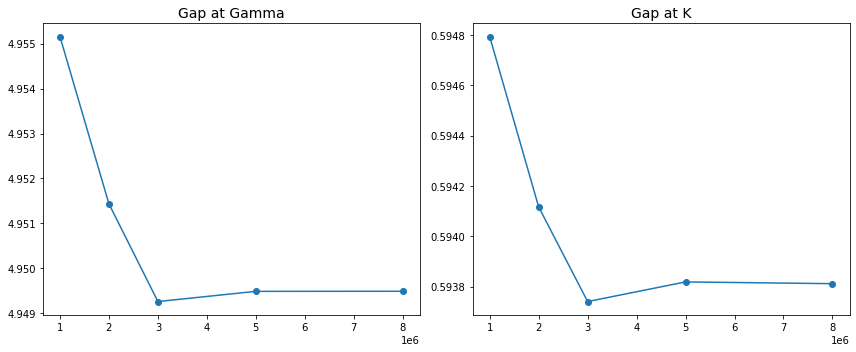

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(RandQpts,gap_G)
axes[0].scatter(RandQpts,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(RandQpts, gap_K)
axes[1].scatter(RandQpts,gap_K)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

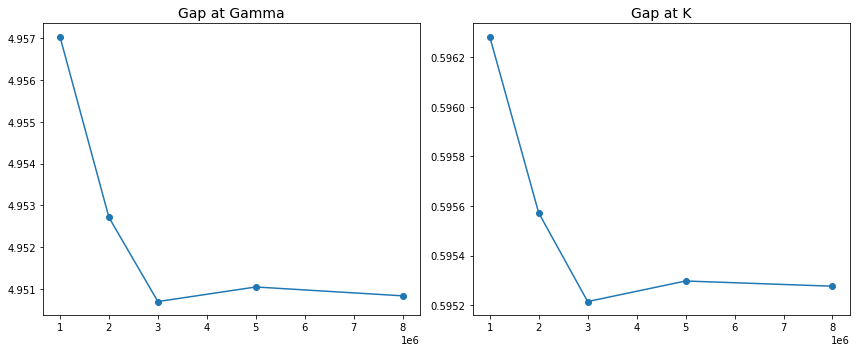

In [28]:
# results for celldm3=6

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(RandQpts,gap_G)
axes[0].scatter(RandQpts,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(RandQpts, gap_K)
axes[1].scatter(RandQpts,gap_K)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We also show the values of the valence and conduction bands

In [30]:
val_G = [r.data['hf']['Ehf'][0] for r in results_G]
cond_G = [r.data['hf']['Ehf'][1] for r in results_G]

val_K = [r.data['hf']['Ehf'][0] for r in results_K]
cond_K = [r.data['hf']['Ehf'][1] for r in results_K]

In [31]:
val_G

[-2.325621, -2.306473, -2.296569, -2.297633, -2.297465]

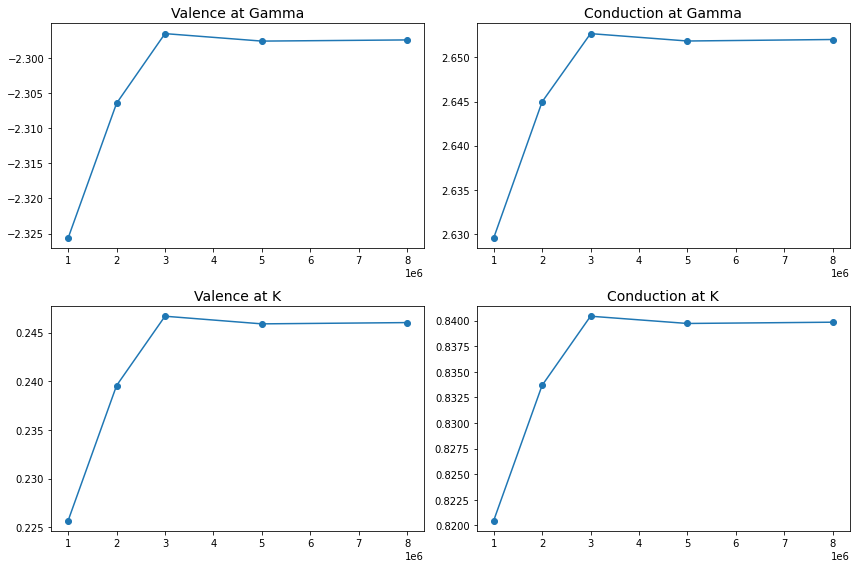

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes[0,0].plot(RandQpts,val_G)
axes[0,0].scatter(RandQpts,val_G)
axes[0,0].set_title('Valence at Gamma',size=14)
axes[0,1].plot(RandQpts, cond_G)
axes[0,1].scatter(RandQpts,cond_G)
axes[0,1].set_title('Conduction at Gamma',size=14)

axes[1,0].plot(RandQpts,val_K)
axes[1,0].scatter(RandQpts,val_K)
axes[1,0].set_title('Valence at K',size=14)
axes[1,1].plot(RandQpts, cond_K)
axes[1,1].scatter(RandQpts,cond_K)
axes[1,1].set_title('Conduction at K',size=14)

fig.tight_layout()

Also for the RandQpts parameter we observe that the gap is converged at the level of 1eV at 1e6 while
the convergence of the individual states requires higher values. 

On the basis of this analysis we choose the converged parameters for the RIM_W and Coulomb cutoff as
* RandGVec = 300
* RandGvecW = 100
* RandQPpts = 5000000

The RandGvecW has not been tested at the level of HF, we choose this value using the HF analysis for the RandGvec as
guideline, but we not push its value too much because the W potential depends on G and G' so increasing too much this
parameter can become too computationally demanding.


## HF Analysis in function of the k-points sampling

Now we test the convergence of the HF gap at $K$ and at the $\Gamma$ points in funciont of the dimension of the $k$-points sampling.

The converged parameters for the RIM and Coulomb cutoff derived in the previous analysis will be used.

In [45]:
RandQpts = 5000000
RandGvec = 300 
RandGvecW = 100

start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index = {30:1,60:1,81:1}
K_index = {30:91,60:331,81:588}

#EXXRLvcs = 40000 # RL # cutoff used with celldm3=6, corresponds to 50 Ha
#EXXRLVcs_units = 'RL'
EXXRLvcs = 50. # Ha # cutoff used with celldm3=4
EXXRLVcs_units = 'Ha'

In [46]:
kpoints = [30,60,81]

In [47]:
study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    #source_dir = 'DFT_analysis/kpoints_%s-nbnds_700.save'%k
    #run_dir = 'GW_HF_analysis/kpoints_%s-nbnds_700'%k
    source_dir = 'DFT_analysis-vac_4/kpoints_%s-nbnds_700.save'%k
    run_dir = 'GW_HF_analysis/kpoints_%s-nbnds_700-vac_4'%k
    Tools.build_SAVE(source_dir,run_dir,command='mpirun -np 1 p2y')
    
    inp = I.YamboInput(args='mpirun -np 1 yambo -r -x -V all',folder=run_dir)
    inp.set_extendOut()
    inp['variables']['EXXRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
    inp['variables']['VXCRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
    inp.set_bandRange(start_band,stop_band)
    inp['variables']['CUTGeo'] = 'slab z'
    inp['variables']['RandGvec'] = [RandGvec,'RL']
    inp['variables']['RandGvecW'] = [RandGvecW,'RL']
    inp['variables']['RandQpts'] = [RandQpts,'']
    inp['variables']['SE_CPU'] = '1.1.16' # for 1 node on ismhpc
    inp['variables']['SE_ROLEs'] = 'q.qp.b'
    
    # append run at G
    idd = 'hf-G-slab_z-kpoints_%s'%k
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)
    # append run at K
    idd = 'hf-K-slab_z-kpoints_%s'%k
    inp.set_kRange(K_index[k],K_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)

Initialize a Dataset with 2 parallel tasks
SAVE folder already present in GW_HF_analysis/kpoints_30-nbnds_700-vac_4. No operations performed.
SAVE folder already present in GW_HF_analysis/kpoints_60-nbnds_700-vac_4. No operations performed.
SAVE folder already present in GW_HF_analysis/kpoints_81-nbnds_700-vac_4. No operations performed.


In [48]:
#study.runs[4]

In [49]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0, 1], [2, 3], [4, 5]] 

Run the task [0, 1] 
Skip the run ofSkip the run of  hf-K-slab_z-kpoints_30hf-G-slab_z-kpoints_30

Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of hf-K-slab_z-kpoints_60
Skip the run of hf-G-slab_z-kpoints_60
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of hf-G-slab_z-kpoints_81Skip the run of
 hf-K-slab_z-kpoints_81
Task [4, 5] ended 
 


In [50]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')

gap_G, gap_K = [],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))

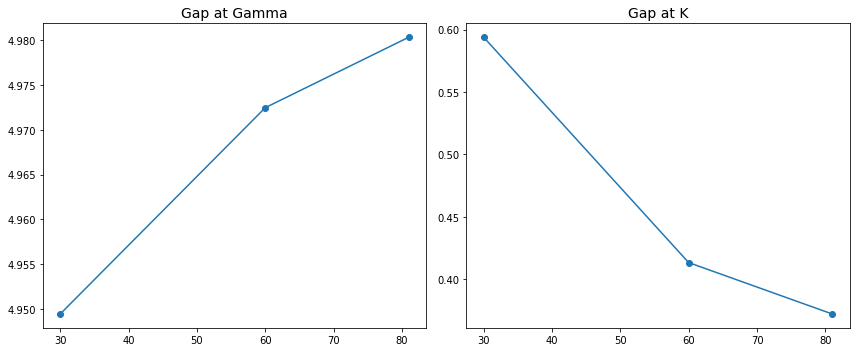

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

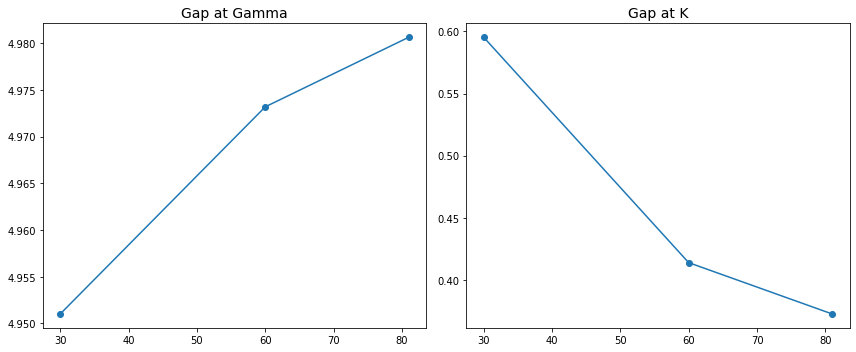

In [31]:
# results for celldm3=6

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

In [32]:
gap_K

[0.595303, 0.41383400000000004, 0.372503]

We perform also these computations without rim and cutoff

In [33]:
#kpoints = [30,60,81]

In [34]:
study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    source_dir = 'DFT_analysis/kpoints_%s-nbnds_700.save'%k
    run_dir = 'GW_HF_analysis/kpoints_%s-nbnds_700'%k
    Tools.build_SAVE(source_dir,run_dir,command='mpirun -np 1 p2y')
    
    inp = I.YamboInput(args='mpirun -np 1 yambo -x -V all',folder=run_dir)
    inp.set_extendOut()
    inp['variables']['EXXRLvcs'] = [EXXRLvcs,'RL']
    inp['variables']['VXCRLvcs'] = [EXXRLvcs,'RL']
    inp.set_bandRange(start_band,stop_band)
    inp['variables']['SE_CPU'] = '1.1.16' # for 1 node on ismhpc
    inp['variables']['SE_ROLEs'] = 'q.qp.b'
    
    # append run at G
    idd = 'hf-G-slab_z-kpoints_%s-norim'%k
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)
    # append run at K
    idd = 'hf-K-slab_z-kpoints_%s-norim'%k
    inp.set_kRange(K_index[k],K_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)

Initialize a Dataset with 2 parallel tasks
SAVE folder already present in GW_HF_analysis/kpoints_30-nbnds_700. No operations performed.
SAVE folder already present in GW_HF_analysis/kpoints_60-nbnds_700. No operations performed.
SAVE folder already present in GW_HF_analysis/kpoints_81-nbnds_700. No operations performed.


In [35]:
#study.runs[1]

In [36]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0, 1], [2, 3], [4, 5]] 

Run the task [0, 1] 
Skip the run of hf-G-slab_z-kpoints_30-norim
Skip the run of hf-K-slab_z-kpoints_30-norim
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of hf-G-slab_z-kpoints_60-norim
Skip the run of hf-K-slab_z-kpoints_60-norim
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of hf-G-slab_z-kpoints_81-norim
Skip the run of hf-K-slab_z-kpoints_81-norim
Task [4, 5] ended 
 


In [37]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')

gap_G_norim, gap_K_norim = [],[]
for ind,k in enumerate(kpoints):
    gap_G_norim.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K_norim.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))

In [38]:
gap_G

[4.951014, 4.97319, 4.980642]

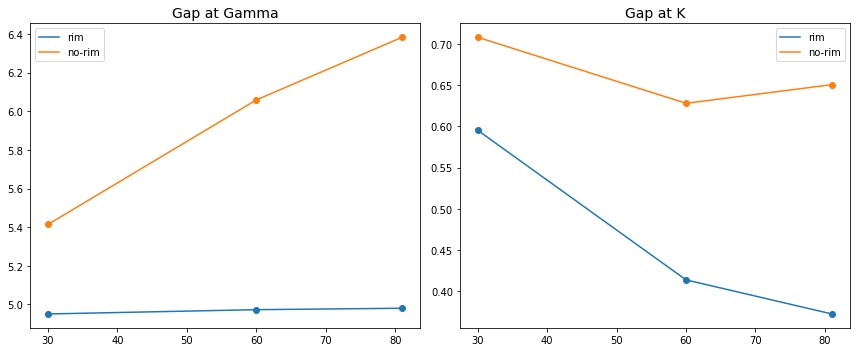

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G,label='rim')
axes[0].scatter(kpoints,gap_G)
axes[0].plot(kpoints,gap_G_norim,label='no-rim')
axes[0].scatter(kpoints,gap_G_norim)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].legend()
axes[1].plot(kpoints, gap_K,label='rim')
axes[1].scatter(kpoints,gap_K)
axes[1].plot(kpoints, gap_K_norim,label='no-rim')
axes[1].scatter(kpoints,gap_K_norim)
axes[1].set_title('Gap at K',size=14)
axes[1].legend()
fig.tight_layout()

## Plasmon pole analysis in function of the k-points sampling

We study the convergence of the gap at $\Gamma$ and at $K$ in function of the k-points sampling. We also investigate the
effects of the double-grid.

The double-grid has been analyzed with celldm3=6, this analysis has shown that the effect of the dg gives rise to
a worst evaluation of the gap at k=30 and is negligible at k=60. For these reasons the db is not implemented further
and the computations with celldm3=4 are performed without the dg

The common parameters in this analysis are

In [26]:
RandQpts = 5000000
RandGvec = 300 
RandGvecW = 100

start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index = {30:1,60:1,81:1}
K_index = {30:91,60:331,81:588}
#EXXRLvcs = 40000 # RL # cutoff used with celldm3=6, corresponds to 50 Ha
#EXXRLVcs_units = 'RL'
EXXRLvcs = 50. # Ha # cutoff used with celldm3=4
EXXRLVcs_units = 'Ha'

#NGsBlkXs = 600 # RL G size of the response function used in the computation with celldm3 = 6, corresponds to 3.7 Ha
#NGsBlkXs_units = 'RL'
NGsBlkXs = 3.7 # Ha G size of the response function used in the computation with celldm3 = 4
NGsBlkXs_units = 'Ha'

BndsRnXs  = [1,300] # Bands in the response function
GbndRnge = [1,700]  # Bands in the Sigma_c

Note that for the response function we use _minimal_ values, a further convergence on these parameters will
be performed later.

We build the double grid ndb using the ypp -m option and we link the "../kpoints_81-nbnds_700" path

In [4]:
run_dir = 'GW_HF_analysis/kpoints_30-nbnds_700'
#run_dir = 'GW_HF_analysis/kpoints_60-nbnds_700'
inp = I.YamboInput(args='mpirun -np 1 ypp -m',folder=run_dir)
inp['variables']['FineGd_DB1_paths'] = ['../kpoints_81-nbnds_700','']
inp.write(run_dir,'ypp_dg.in')

Than we execute ypp with this input file and we move ndb.Double_Grid database built in the SAVE into a specific
folder so that it can be used only when needed.

In [27]:
kpoints = [30,60,81]

In [28]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    #source_dir = 'DFT_analysis/kpoints_%s-nbnds_700.save'%k
    #run_dir = 'GW_HF_analysis/kpoints_%s-nbnds_700'%k
    source_dir = 'DFT_analysis-vac_4/kpoints_%s-nbnds_700.save'%k
    run_dir = 'GW_HF_analysis/kpoints_%s-nbnds_700-vac_4'%k
    #Tools.build_SAVE(source_dir,run_dir,command='mpirun -np 1 p2y')
    
    inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
    inp.set_extendOut() 
    inp['arguments'].append('RIM_W') # activate the RIM_W 
    inp['variables']['EXXRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
    inp['variables']['VXCRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
    inp['variables']['NGsBlkXp'] = [NGsBlkXs,NGsBlkXs_units]
    inp['variables']['BndsRnXp'] = [BndsRnXs,'']
    inp['variables']['GbndRnge'] = [GbndRnge,'']
    inp.set_bandRange(start_band,stop_band)
    
    inp['variables']['CUTGeo'] = 'slab z'
    inp['variables']['RandGvec'] = [RandGvec,'RL']
    inp['variables']['RandGvecW'] = [RandGvecW,'RL']
    inp['variables']['RandQpts'] = [RandQpts,'']
    
    inp['variables']['SE_CPU'] = '2.1.16' # for 2 nodes on ismhpc or 8 nodes on 100
    #inp['variables']['SE_CPU'] = '2.2.16' # for 16 nodes on m100
    inp['variables']['SE_ROLEs'] = 'q.qp.b'
    inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
    inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
    inp['variables']['DIP_ROLEs'] = 'k.c.v'
    inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

    # append run at G
    idd = 'pp-G-slab_z-kpoints_%s'%k
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_gamma','ndb_pp-ngsblkxs_%s-bndsrnxs_300'%NGsBlkXs])
    # append run at K
    idd = 'pp-K-slab_z-kpoints_%s'%k
    inp.set_kRange(K_index[k],K_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_k','ndb_pp-ngsblkxs_%s-bndsrnxs_300'%NGsBlkXs])
    
    if k == -1: # != 81:
        #append run at G with double grid
        idd = 'pp-G_double_grid-slab_z-kpoints_%s'%k
        inp.set_kRange(Gamma_index[k],Gamma_index[k])
        study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_gamma','ndb_double_grid',
                              'ndb_pp_dg-ngsblkxs_600-bndsrnxs_300'])
        #append run at K with double grid
        idd = 'pp-K_double_grid-slab_z-kpoints_%s'%k
        inp.set_kRange(K_index[k],K_index[k])
        study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_k','ndb_double_grid',
                              'ndb_pp_dg-ngsblkxs_600-bndsrnxs_300'])

16 2
Initialize a Dataset with 1 parallel tasks


In [25]:
#study.runs[0]

In [29]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0], [1], [2], [3], [4], [5]] 

Run the task [0] 
Skip the run of pp-G-slab_z-kpoints_30
Task [0] ended 
 
Run the task [1] 
Skip the run of pp-K-slab_z-kpoints_30
Task [1] ended 
 
Run the task [2] 
Skip the run of pp-G-slab_z-kpoints_60
Task [2] ended 
 
Run the task [3] 
Skip the run of pp-K-slab_z-kpoints_60
Task [3] ended 
 
Run the task [4] 
Skip the run of pp-G-slab_z-kpoints_81
Task [4] ended 
 
Run the task [5] 
Skip the run of pp-K-slab_z-kpoints_81
Task [5] ended 
 


In [30]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
#results_G_dg, results_K_dg = study.fetch_results(id='-G_double_grid-'),study.fetch_results(id='-K_double_grid-')

gap_G, gap_K,gap_G_dg, gap_K_dg = [],[],[],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
#for ind,k in enumerate(kpoints[:-1]):
#    gap_G_dg.append(results_G_dg[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
#    gap_K_dg.append(results_K_dg[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))

In [31]:
gap_G,gap_G_dg,gap_K,gap_K_dg

([0.925404, 0.536946, 0.450689],
 [],
 [0.29137700000000005, 0.135652, 0.10341800000000001],
 [])

In [10]:
# norimw
gap_G,gap_G_dg,gap_K,gap_K_dg

([0.5815229999999999], [], [0.23282800000000003], [])

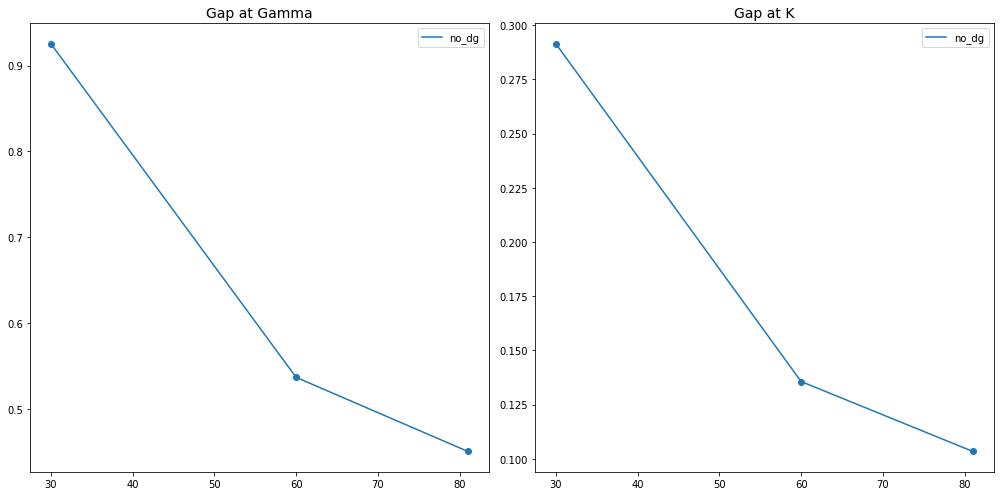

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].plot(kpoints,gap_G,label='no_dg')
axes[0].scatter(kpoints,gap_G)
#axes[0].plot(kpoints[:-1],gap_G_dg,label='dg')
#axes[0].scatter(kpoints[:-1],gap_G_dg)
axes[0].legend()
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(kpoints, gap_K,label='no_dg')
axes[1].scatter(kpoints,gap_K)
#axes[1].plot(kpoints[:-1],gap_K_dg,label='dg')
#axes[1].scatter(kpoints[:-1],gap_K_dg)
axes[1].legend()
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

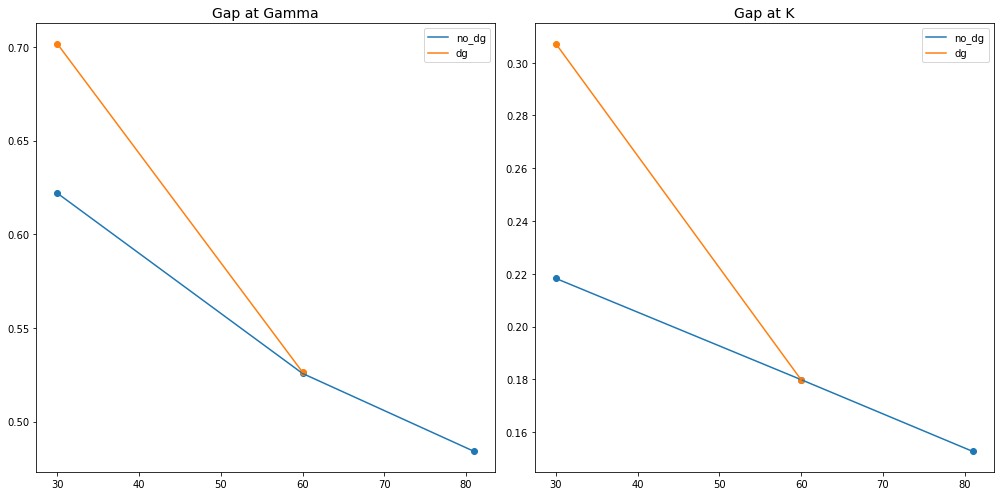

In [22]:
# results for celldm3=6

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].plot(kpoints,gap_G,label='no_dg')
axes[0].scatter(kpoints,gap_G)
axes[0].plot(kpoints[:-1],gap_G_dg,label='dg')
axes[0].scatter(kpoints[:-1],gap_G_dg)
axes[0].legend()
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(kpoints, gap_K,label='no_dg')
axes[1].scatter(kpoints,gap_K)
axes[1].plot(kpoints[:-1],gap_K_dg,label='dg')
axes[1].scatter(kpoints[:-1],gap_K_dg)
axes[1].legend()
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We analyze the convergence of the correlation part of the self energy

In [41]:
sc_gamma_val = np.array([r.data['qp']['sce0'][0] for r in results_G])
sc_gamma_con = np.array([r.data['qp']['sce0'][1] for r in results_G])

sc_k_val = np.array([r.data['qp']['sce0'][0] for r in results_K])
sc_k_con = np.array([r.data['qp']['sce0'][1] for r in results_K])

In [43]:
sc_gamma_val,sc_gamma_con,sc_k_val,sc_k_con

(array([0.694234, 0.753359, 0.765355]),
 array([-4.037687, -4.130351, -4.151757]),
 array([-1.282558, -1.3231  , -1.335407]),
 array([-1.689573, -1.64963 , -1.637463]))

In [46]:
sc_gamma_gap = sc_gamma_con-sc_gamma_val
sc_k_gap = sc_k_con-sc_k_val
sc_gamma_gap,sc_k_gap

(array([-4.731921, -4.88371 , -4.917112]),
 array([-0.407015, -0.32653 , -0.302056]))

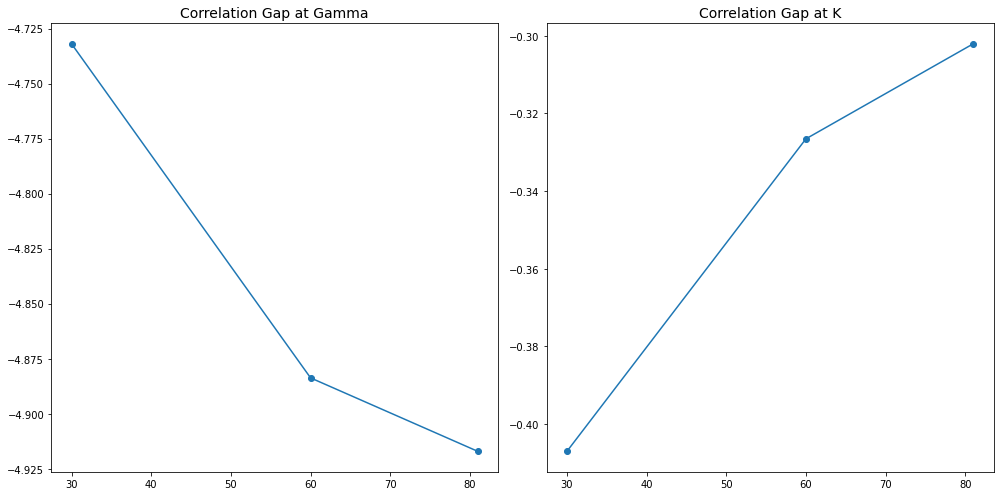

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].plot(kpoints,sc_gamma_gap)
axes[0].scatter(kpoints,sc_gamma_gap)
axes[0].set_title('Correlation Gap at Gamma',size=14)
axes[1].plot(kpoints,sc_k_gap)
axes[1].scatter(kpoints,sc_k_gap)
axes[1].set_title('Correlation Gap at K',size=14)
fig.tight_layout()

These plots evidence that also the correlation part of the gap convergen slowly w.r.t the kpoints sampling.

## Convergence analysis of the screening at the PP level 

We perform a convergence analysis of the ndb.pp at the plasmon pole level in terms of the NGsBlkXs and
of the BndsRnXs parameters. This analysis is performed on the 30x30x1 kpoints sampling. We use the gap
at $\Gamma$ and at $K$ as convergence test observables. 

In [4]:
RandQpts = 5000000
RandGvec = 300 
RandGvecW = 100

start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index = {30:1,60:1,81:1}
K_index = {30:91,60:331,81:588}
EXXRLvcs = 50. # Ha # cutoff used with celldm3=4
EXXRLVcs_units = 'Ha'

GbndRnge = [1,700]  # Bands in the Sigma_c

run_dir = 'GW_HF_analysis/kpoints_30-nbnds_700-vac_4'
k = 30

First we run over the NGsBlkXs parameter

In [5]:
BndsRnXs  = [1,300] # Bands in the response function

NGsBlkXs_vals = [3.7,5,6,10]
NGsBlkXs_units = 'Ha'

In [6]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)
    
inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut() 
inp['arguments'].append('RIM_W') # activate the RIM_W 
inp['variables']['EXXRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['VXCRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['BndsRnXp'] = [BndsRnXs,'']
inp['variables']['GbndRnge'] = [GbndRnge,'']
inp.set_bandRange(start_band,stop_band)
    
inp['variables']['CUTGeo'] = 'slab z'
inp['variables']['RandGvec'] = [RandGvec,'RL']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']
inp['variables']['RandQpts'] = [RandQpts,'']
    
inp['variables']['SE_CPU'] = '2.1.16' # for 2 nodes on ismhpc or 8 nodes on 100
#inp['variables']['SE_CPU'] = '2.2.16' # for 16 nodes on m100
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

for ngsblkxs in NGsBlkXs_vals:
    # append run at G
    idd = 'pp-G-eps_conv-ngsblkxs_%s-bndsrnxs_300'%ngsblkxs
    inp['variables']['NGsBlkXp'] = [ngsblkxs,NGsBlkXs_units]
    inp.set_kRange(Gamma_index[30],Gamma_index[30])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_gamma','ndb_pp-ngsblkxs_%s-bndsrnxs_300'%ngsblkxs])
    # append run at K
    idd = 'pp-K-eps_conv-ngsblkxs_%s-bndsrnxs_300'%ngsblkxs
    inp['variables']['NGsBlkXp'] = [ngsblkxs,NGsBlkXs_units]
    inp.set_kRange(K_index[30],K_index[30])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_K','ndb_pp-ngsblkxs_%s-bndsrnxs_300'%ngsblkxs])
    

16 2
Initialize a Dataset with 1 parallel tasks


In [11]:
#study.runs[7]

In [7]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0], [1], [2], [3], [4], [5], [6], [7]] 

Run the task [0] 
Skip the run of pp-G-eps_conv-ngsblkxs_3.7-bndsrnxs_300
Task [0] ended 
 
Run the task [1] 
Skip the run of pp-K-eps_conv-ngsblkxs_3.7-bndsrnxs_300
Task [1] ended 
 
Run the task [2] 
Skip the run of pp-G-eps_conv-ngsblkxs_5-bndsrnxs_300
Task [2] ended 
 
Run the task [3] 
Skip the run of pp-K-eps_conv-ngsblkxs_5-bndsrnxs_300
Task [3] ended 
 
Run the task [4] 
Skip the run of pp-G-eps_conv-ngsblkxs_6-bndsrnxs_300
Task [4] ended 
 
Run the task [5] 
Skip the run of pp-K-eps_conv-ngsblkxs_6-bndsrnxs_300
Task [5] ended 
 
Run the task [6] 
Skip the run of pp-G-eps_conv-ngsblkxs_10-bndsrnxs_300
Task [6] ended 
 
Run the task [7] 
run command: mpirun -np 32 yambo -F pp-K-eps_conv-ngsblkxs_10-bndsrnxs_300.in -J "pp-K-eps_conv-ngsblkxs_10-bndsrnxs_300,ndb_rim_cutoff,ndb_dipoles,ndb_hf_K,ndb_pp-ngsblkxs_10-bndsrnxs_300" -C pp-K-eps_conv-ngsblkxs_10-bndsrnxs_300

In [8]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
#results_G_dg, results_K_dg = study.fetch_results(id='-G_double_grid-'),study.fetch_results(id='-K_double_grid-')

gap_G, gap_K = [],[]
for ind in range(len(NGsBlkXs_vals)):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))


In [9]:
gap_G,gap_K

([0.925404, 0.9250910000000001, 0.9245510000000001, 0.925053],
 [0.29137700000000005, 0.29316500000000006, 0.293586, 0.293862])

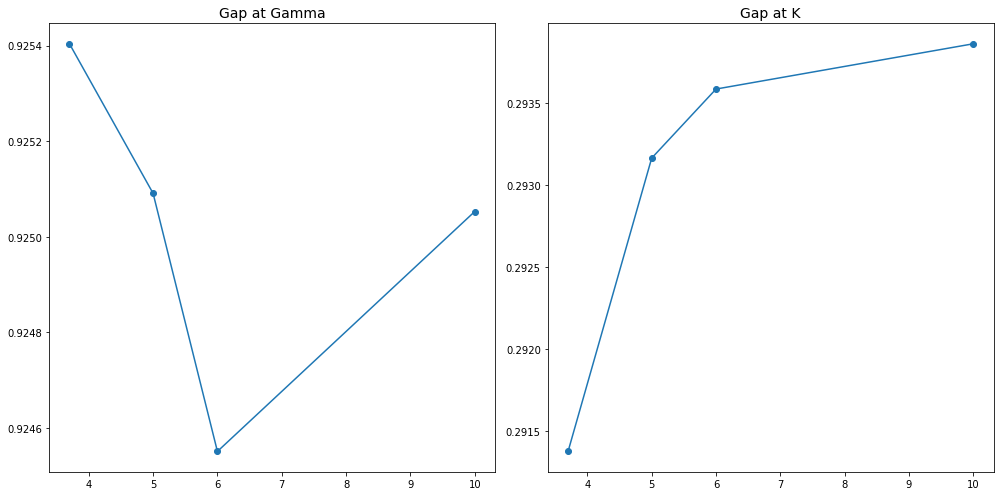

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].plot(NGsBlkXs_vals,gap_G)
axes[0].scatter(NGsBlkXs_vals,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(NGsBlkXs_vals, gap_K)
axes[1].scatter(NGsBlkXs_vals,gap_K)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

On the basis of this analysis we choose NGsBlkXs = 5 Ha as converged value.

Then we run over BndsRnXs

In [5]:
NGsBlkXs = 5
NGsBlkXs_units = 'Ha'

BndsRnXs_vals  = [[1,300],[1,400],[1,500]] # Bands in the response function

In [11]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

study = D.Dataset(num_tasks=8,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)
    
inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut() 
inp['arguments'].append('RIM_W') # activate the RIM_W 
inp['variables']['EXXRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['VXCRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['NGsBlkXp'] = [NGsBlkXs,NGsBlkXs_units]
inp['variables']['GbndRnge'] = [GbndRnge,'']
inp.set_bandRange(start_band,stop_band)
    
inp['variables']['CUTGeo'] = 'slab z'
inp['variables']['RandGvec'] = [RandGvec,'RL']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']
inp['variables']['RandQpts'] = [RandQpts,'']
    
inp['variables']['SE_CPU'] = '2.1.16' # for 2 nodes on ismhpc or 8 nodes on 100
#inp['variables']['SE_CPU'] = '2.2.16' # for 16 nodes on m100
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

for bndsrnxs in BndsRnXs_vals:
    # append run at G
    idd = 'pp-G-eps_conv-ngsblkxs_5-bndsrnxs_%s'%bndsrnxs[1]
    inp['variables']['BndsRnXp'] = [bndsrnxs,'']
    inp.set_kRange(Gamma_index[30],Gamma_index[30])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_gamma','ndb_pp-ngsblkxs_5-bndsrnxs_%s'%bndsrnxs[1]])
    # append run at K
    idd = 'pp-K-eps_conv-ngsblkxs_5-bndsrnxs_%s'%bndsrnxs[1]
    inp['variables']['BndsRnXp'] = [bndsrnxs,'']
    inp.set_kRange(K_index[30],K_index[30])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_K','ndb_pp-ngsblkxs_5-bndsrnxs_%s'%bndsrnxs[1]])
    

16 2
Initialize a Dataset with 8 parallel tasks


In [12]:
#study.runs[4]

In [ ]:
results = study.run(selection=[2,4])

Run the selection [2, 4] with the parallel task_groups [[2, 4]] 

Run the task [2, 4] 
run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F pp-G-eps_conv-ngsblkxs_5-bndsrnxs_400.in -J "pp-G-eps_conv-ngsblkxs_5-bndsrnxs_400,ndb_rim_cutoff,ndb_dipoles,ndb_hf_gamma,ndb_pp-ngsblkxs_5-bndsrnxs_400" -C pp-G-eps_conv-ngsblkxs_5-bndsrnxs_400
slurm submit: run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F pp-G-eps_conv-ngsblkxs_5-bndsrnxs_500.in -J "pp-G-eps_conv-ngsblkxs_5-bndsrnxs_500,ndb_rim_cutoff,ndb_dipoles,ndb_hf_gamma,ndb_pp-ngsblkxs_5-bndsrnxs_500" -C pp-G-eps_conv-ngsblkxs_5-bndsrnxs_500 
cd GW_HF_analysis/kpoints_30-nbnds_700-vac_4 ; sbatch job_pp-G-eps_conv-ngsblkxs_5-bndsrnxs_400.shslurm submit: 
 cd GW_HF_analysis/kpoints_30-nbnds_700-vac_4 ; sbatch job_pp-G-eps_conv-ngsblkxs_5-bndsrnxs_500.sh
computation pp-G-eps_conv-ngsblkxs_5-bndsrnxs_400 is running...
computation pp-G-eps_conv-ngsblkxs_5-bndsrnxs_500 is running...
Submitted batch job 6